In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, StackingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv('data/cleaned_review_data.csv', index_col = 0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200831 entries, 0 to 999998
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   review_id               200831 non-null  object 
 1   user_id                 200831 non-null  object 
 2   business_id             200831 non-null  object 
 3   stars                   200831 non-null  float64
 4   useful                  200831 non-null  int64  
 5   funny                   200831 non-null  int64  
 6   cool                    200831 non-null  int64  
 7   text                    200831 non-null  object 
 8   date                    200831 non-null  object 
 9   year                    200831 non-null  int64  
 10  month                   200831 non-null  int64  
 11  day                     200831 non-null  int64  
 12  hour                    200831 non-null  int64  
 13  min                     200831 non-null  int64  
 14  sec                 

In [4]:
df['stars'] = df['stars'].astype('int64')

<AxesSubplot:>

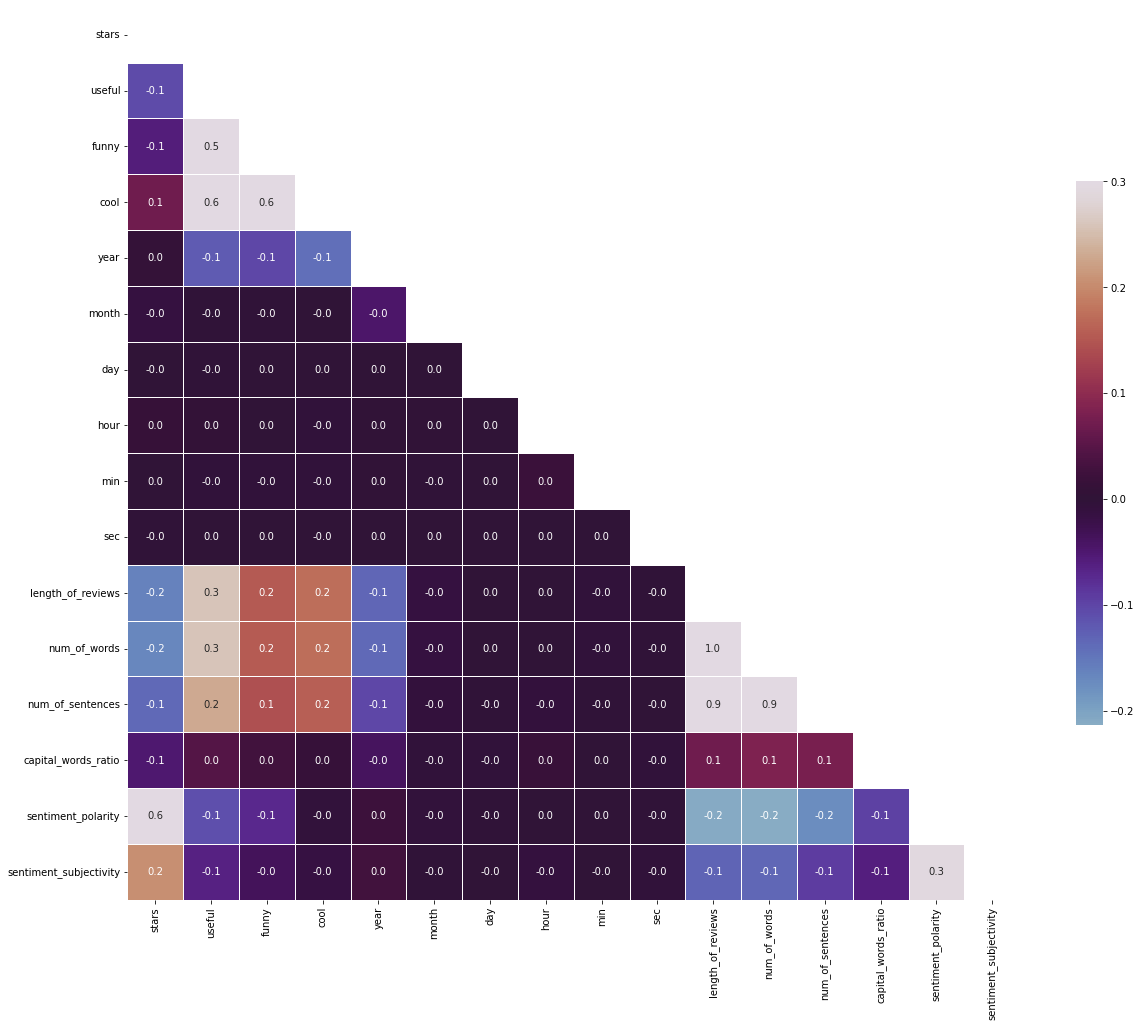

In [5]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, fmt=".1f", mask=mask, cmap='twilight', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [6]:
# CLASSIFICATION
data_classes = df[(df['stars']==1) | (df['stars']==3) | (df['stars']==5)]
data_classes.head()
print(data_classes.shape)

(130684, 22)


In [7]:
X = data_classes.drop(columns=['stars', 'review_id', 'user_id', 'business_id', 'text', 'date', 'month', 'day', 'hour', 'min', 'cleaned_text'])
y = data_classes['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [8]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### Model Selection

In [10]:
models = [ KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), xgb.XGBClassifier()]

for ml in models:
    
    ### train
    ml.fit(X_train, y_train)
    
    ### predict
    y_pred = ml.predict(X_test)
 
    print(ml, 'test accuracy:', ml.score(X_test, y_test))
    # print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test, y_pred))

/Users/yonniechan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/yonniechan/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

KNeighborsClassifier() test accuracy: 0.696101312315874
[[ 3401   671   947]
 [  969  1054  2761]
 [  961  1634 13739]]
DecisionTreeClassifier() test accuracy: 0.6434173776638482
[[ 3049   924  1046]
 [  882  1360  2542]
 [ 1030  2896 12408]]
RandomForestClassifier() test accuracy: 0.7492061062861078
[[ 3686   353   980]
 [  815   824  3145]
 [  609   653 15072]]
GradientBoostingClassifier() test accuracy: 0.7538355587863947
[[ 3722   354   943]
 [  798   823  3163]
 [  603   573 15158]]
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
     

### Hyperparameter tuning

In [11]:
# params = {'learning_rate': [0.1, 0.05, 0.001],
#           'n_estimators': range(50, 150, 50), 
#         #   'subsample': [0.8, 1], 
#           # 'criterion':'friedman_mse', 
#           # 'min_samples_split': [600, 800, 1000, 1200], 
#           'min_samples_leaf': [50, 100, 150],
#           # 'min_weight_fraction_leaf': 0.0, 
#           'max_depth': range(3, 11, 2), # usually 5-8
#           # 'min_impurity_decrease': 0.0, 
#           # 'max_features':None, 
#           # 'alpha':0.9, 
#           # 'verbose':0, 
#           # 'max_leaf_nodes':None, 
#           # 'warm_start':False, 
#           # 'validation_fraction':0.1, 
#           # 'n_iter_no_change':None, 
#           # 'tol':0.0001,
#           # 'ccp_alpha':0.0
#           }

# model = GradientBoostingClassifier()

# grid_search = GridSearchCV(
#     estimator = model,
#     param_grid = params,
#     scoring = "recall"
# )
# grid_search.fit(X_train, y_train)

# gb_best_params = grid_search.best_params_
# print("best_parameters: ", gb_best_params)
# # print("best_model_score: ", grid_search.score(X_test, y_test))

# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
# print('Precision Score : ' + str(precision_score(y_test,y_pred)))
# print('Recall Score : ' + str(recall_score(y_test,y_pred)))
# print('F1 Score : ' + str(f1_score(y_test,y_pred)))

# confusion_matrix(y_test,y_pred)

In [12]:
# params = {
#           'objective':['binary:logistic'],
#           'learning_rate': [0.001, 0.05, 0.1], #so called `eta` value
#           'max_depth': range(3, 9, 2),
#             #   'min_child_weight': [4],
#             #   'silent': [1],
#             #   'subsample': [0.7],
#             #   'colsample_bytree': [0.7],
#           'n_estimators': range(50, 150, 50)
#           }

# model = xgb.XGBClassifier()

# grid_search = GridSearchCV(
#     estimator = model,
#     param_grid = params,
#     scoring = "recall"
# )
# grid_search.fit(X_train, y_train)


# xgb_best_params = grid_search.best_params_
# print(grid_search.best_score_, xgb_best_params)
# print("best_parameters: ", xgb_best_params)
# # print("best_model_score: ", grid_search.score(X_test, y_test))

# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
# print('Precision Score : ' + str(precision_score(y_test,y_pred)))
# print('Recall Score : ' + str(recall_score(y_test,y_pred)))
# print('F1 Score : ' + str(f1_score(y_test,y_pred)))

# confusion_matrix(y_test,y_pred)

### Final Model

In [13]:
# estimators = [
#     ('rf', RandomForestClassifier()),
#     ('gb', GradientBoostingClassifier(**gb_best_params)), 
#     ('xgb',xgb.XGBClassifier(**xgb_best_params))
# ] 

# clf = StackingClassifier(
#     estimators = estimators,
#     final_estimator = GradientBoostingClassifier(**gb_best_params), 
#     cv = 5
# )

# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

# print(ml, 'Stacking test accuracy:', clf.score(X_test, y_test))
# # print(ml, 'train accuracy:', ml.score(X_train, y_train))

# print(classification_report(y_test,y_pred))
# # metrics.plot_roc_curve(ml, X_test, y_test)

# # confusion_matrix(y_test, y_pred)
# # pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

In [14]:
clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)

X_ = np.concatenate((X_train, X_test))
y_ = np.concatenate((y_train, y_test))

y_pred = clf.predict(X_)

print('Test accuracy:', clf.score(X_, y_))

print(confusion_matrix(y_, y_pred))

print(classification_report(y_, y_pred))

Test accuracy: 0.7550350463713997
[[18642  1700  4612]
 [ 4063  4245 15830]
 [ 2933  2875 75784]]
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     24954
           1       0.48      0.18      0.26     24138
           2       0.79      0.93      0.85     81592

    accuracy                           0.76    130684
   macro avg       0.67      0.62      0.62    130684
weighted avg       0.72      0.76      0.72    130684



### Filter out fake reviews

In [15]:
final_df = pd.concat((X, y), axis = 1)
# convert encoder to original scale
final_df['pred_stars'] = y_pred+1

In [16]:
final_df = final_df[abs(final_df['pred_stars']-final_df['stars'])<4]
final_df

,useful,funny,cool,year,sec,length_of_reviews,num_of_words,num_of_sentences,capital_words_ratio,sentiment_polarity,sentiment_subjectivity,stars,pred_stars
0,0,0,0,2018,11,513,114,7,0.026316,0.209722,0.419444,3,3
1,1,0,1,2012,18,829,174,7,0.011494,0.395455,0.571212,5,3
3,1,0,1,2015,3,243,56,6,0.000000,0.279545,0.713068,5,3
5,1,2,1,2015,31,341,79,10,0.063291,0.211111,0.405556,1,3
7,2,0,0,2015,16,192,34,4,0.029412,0.505556,0.788889,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999947,0,0,0,2010,8,614,127,9,0.007874,0.416667,0.654167,5,3
999960,0,0,0,2011,59,1386,304,12,0.049342,0.395076,0.609343,5,3
999976,2,0,0,2012,41,630,134,8,0.089552,-0.135000,0.449167,1,3
999997,0,0,0,2016,29,2970,624,21,0.038462,0.130908,0.524250,3,3


In [17]:
final_df.to_csv('data/review_data_without_fake.csv')